# Sagemaker JumpStart + HuggingFace Embeddings + Langchain

## This is a Level 200 Instructor Led Lab

## Part 0 - Set Up Your Jupyter notebook

### 00a. Set Kernel for your Jupyter notebook

### For this Sagemaker Studio notebook, we will be using the following:
- instance: ml.t3.medium
- kernel: python 3
- Data Science 3.0

### Follow instructions provided in your lab to set up the Jupyter notebook kernel...

***<span>Important - failure to set the right kernel will result in errors during execution of the Jupyter notebook cells</span>***

### Sagemaker Studio uses Jupyter notebooks
Jupyter notebooks use Python. Python is an interpretter language i.e. it does not need to be compiled. The Jupyter notebook has cells. Each cell can be executed independly and shares the same runtime memory, so any variables set can be used across the notebook. The format of the notebook allows for experimentation on the fly...  

### 00b. Update SageMaker LLM Endpoint Name

We will leverage the jumpstart-dft-falcon-7b-instruct-bf16 model you deployed directly using SageMaker JumpStart

- jumpstart-dft-falcon-7b-instruct-bf16

Update this configuration section to replace the value of 'endpoint_name' with the name of your deployed model

In [ ]:
_MODEL_CONFIG_ = {
    
    "jumpstart-dft-hf-llm-falcon-7b-instruct-bf16" : {
        "aws_region": "us-west-2",
        "endpoint_name": "jumpstart-dft-hf-llm-falcon-7b-instruct-bf16"
    },
}

## Part 1 - Set Up

### 01a. Lab Overview


## What is LangChain?
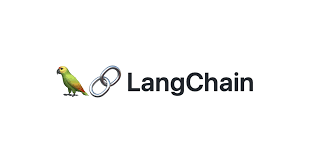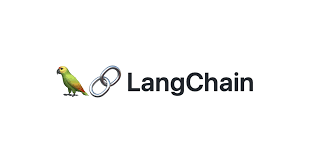

LangChain is a framework for developing applications powered by language models. 

**LLMs are powerful by themselves. Why do we need libraries like LangChain?**
LangChain provides a level of abstraction, making it super easy to use. LangChain's popularity has grown exponentially since it was first introduced and being an open source library, it is constantly evolving!

### 01b. Set up workshop dependencies

In [ ]:
!pip install --upgrade -q pip
!pip install --upgrade -q langchain
!pip install -q transformers
!pip install -q faiss-gpu
!pip install -q bs4
!pip install -q sentence-transformers

In [ ]:
import langchain

print(langchain.__version__)
# assert int(langchain.__version__.split(".")[-1]) >= 194

### 01c. Initialize text artifacts that we will use in this lab

In this hands-on lab, we will experiment with multiple text artifacts, like text, documents, chat messages.

### Schemas
Langchain contains 4 schemas that are used for different tasks - Text, ChatMessages, Examples, Document. Here is the documentation of Schema in Langchain: https://docs.langchain.com/docs/components/schema/

In this section, we will explore examples on how Text, Document and ChatMessages can be used, in the example of a virtual flower shop.

### Text
Text is the most basic form when working with LLM. LLM consumes texts and output texts.

In [ ]:
# You'll be working with simple strings (that'll soon grow in complexity!)
my_text = "How does a lily flower look like?"

### Documents
Document schema are useful as it provides a method to store unstructured data, alongside with metadata associated with it. Interacting with unstructured data is widely used in LLM applications. The metadata help to give more concise information about the piece of Document, which improve efficiency in use cases like document search.

In [ ]:
# loading the required libraries
from langchain.schema import Document

page_content ="""The 'AWSome Flower' shop was founded in 2023. It was founded by three founders in Singapore. It offers a fully virtual experience.
This flower shop opens daily from 7 am to 9 pm except on public holidays."""

# we will load the LangChain Papers as an example 
my_document = Document(page_content=page_content,
         metadata={
             'my_document_id' : 234234,
             'my_document_source' : "The LangChain Papers",
             'my_document_create_time' : 1680013019
         })

### Chat Messages
Building conversational applications with LLM is common. ChatMessages help with adding in pre-configuration on the expected behaviour of the chatbot. Below shows an example on how it can be used to pre-configure a chatbot to behave as a virtual flower shop assistant. Try with different system message and see how it affects the output as we move along the lab!

In [ ]:
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain.schema import HumanMessage, SystemMessage, AIMessage

In [ ]:
# SystemMessage and HumanMessage are wrappers around Prompts being sent to the deployed LLM models
# SystemMessage - Provides instruction to the LLM model on how we expect it to behave
# HumanMessage - not required, but helps seed the LLM model on what it could expect
[
    SystemMessage(content="You are a nice AI bot that helps a user figure out what flower to buy in one short sentence"),
    HumanMessage(content="I like red, what flower should I buy?")
]

## Part 2 - Initialize the LangChain library with your deployed model endpoint
This is how Langchain and SageMaker endpoint can be integrated. Do take note that different LLMs may require different ContentHandler definition for it to work.

In [ ]:
import json
from langchain.llms.sagemaker_endpoint import LLMContentHandler, SagemakerEndpoint

# These are hyper-parameters; Hyperparameters are used before inferencing a model because they have a
# direct impact on the performance of the resulting machine learning model. 
# Hyperparameters are used before inferencing a model because they control the behavior of the model, 
# and optimize its performance for the job at hand.
# For this workshop, hyper parameters have been identified for you...  
parameters ={
        "max_new_tokens": 600,
        "num_return_sequences": 1,
        "top_k": 1,
        "top_p": 0.01,
        "do_sample": False,
        "return_full_text": False,
        "temperature": 0.2
}

# A function that helps handle the JSON messages going in and out of the LLM 
class ContentHandler(LLMContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, prompt: str, model_kwargs={}) -> bytes:
        input_str = json.dumps({"inputs": prompt, "parameters": model_kwargs})
        return input_str.encode("utf-8")

    def transform_output(self, output: bytes) -> str:
        response_json = json.loads(output.read().decode("utf-8"))
        return response_json[0]["generated_text"]


content_handler = ContentHandler()

# Passing the SagemakerEndPoint to LangChain so that it knows where to send all the inference requests
sm_llm_falcon_instruct = SagemakerEndpoint(
    endpoint_name=_MODEL_CONFIG_["jumpstart-dft-hf-llm-falcon-7b-instruct-bf16"]["endpoint_name"],
    region_name=_MODEL_CONFIG_["jumpstart-dft-hf-llm-falcon-7b-instruct-bf16"]["aws_region"],
    model_kwargs=parameters,
    content_handler=content_handler,
)

In [ ]:
# testing our Sagemaker JumpStart inference end point with a simple message to the LLM, through LangChain
print(my_text)
sm_llm_falcon_instruct(my_text)

## Part 3 - Understand text embeddings & see semantic search in action

Here, we are loading the embedding model from hugging face via Langchain. Hugging face have many integrations with Langchain. Here is a link to the documentation to learn more: https://python.langchain.com/docs/integrations/providers/huggingface

In [ ]:
# Initialize the Huggingface Embeddings Model
from langchain.embeddings import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings()

You can also specify a specific embedding model to use. This will load the embedding model in memory. Typically, you might want to host embedding model on an endpoint or invoke it via API as a service such as Bedrock Titan Embeddings.

In [ ]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [ ]:
text = "Hi! It's time to see some beautiful sakura flowers."

text_embedding = embeddings.embed_query(text)
print (f"Your embedding is length {len(text_embedding)}")
print (f"Here's a sample: {text_embedding[:5]}...")

In [ ]:
text_1= "Is it time for sakura viewing yet?"
text_2 = "Yes, we need to go Japan now."
doc_embedding = embeddings.embed_documents([text_1, text_2])
print (f"Your embedding is length {len(doc_embedding[0])}")
print (f"Here's the first text: {doc_embedding[0][:5]}...")
print (f"Here's the second text: {doc_embedding[1][:5]}...")

In [ ]:
from sklearn.preprocessing import normalize
import seaborn as sns
import numpy as np

def plot_similarity_heatmap(text_labels, embeddings, rotation):
    """Takes sentences, embeddings and rotation as input and plot similarity heat map.

    Args:
      text_labels: a list of sentences to compute semantic textual similarity search.
      embeddings: a list of embedding vectors, each of which corresponds to a sentence.
      rotation: rotation used for display of the text_labels.
    """
    inner_product = np.inner(embeddings, embeddings)
    sns.set(font_scale=1.1)
    graph = sns.heatmap(
        inner_product,
        xticklabels=text_labels,
        yticklabels=text_labels,
        vmin=np.min(inner_product),
        vmax=1,
        cmap="OrRd",
    )
    graph.set_xticklabels(text_labels, rotation=rotation)
    graph.set_title("Semantic Textual Similarity Between Sentences")
    
sentences = [
    # Flower order
    "How much is 2 bouquet of roses?",
    "Can I get 5 stems of sunflowers?",
    "Plese get me some roses tomorrow.",
    # Flower information
    "Jasmine is a genus of flowering plants in the family Jasminaceae.",
    "Tulips is also known as Tulipa as its scientific name, as part of Liliaceae family.",
    # Shop
    "What time does your shop close?",
    "How can I visit your shop?",
]

doc_emb = embeddings.embed_documents(sentences)
plot_similarity_heatmap(
    sentences, normalize(
    np.array(doc_emb), axis=1), 
    90
)

## Part 4 - Experiment with prompt and prompt templates
Langchain offers a simple way for us to manage our prompts.

In [ ]:
prompt = """
Rose is white and violets are red.

What is wrong with that statement?
"""

sm_llm_falcon_instruct(prompt)

### Prompt Template
Prompt template allow us to define a base template with variables that can be injected in during runtime, according to the user's input. You can have multiple variables per prompt. 

Try editing the below prompt to adapt to accepting a multi-variable input! Here is the link to the documentation for more information: https://python.langchain.com/docs/modules/model_io/prompts/prompt_templates/

In [ ]:
from langchain import PromptTemplate

# Notice "flower_name" below, that is a placeholder for another value later
template = """
I want to see {flower_name} flower. Where should I go?

Respond in 300 words
"""

prompt = PromptTemplate(
    input_variables=["flower_name"],
    template=template,
)

final_prompt = prompt.format(flower_name='Sakura')

print (f"Final Prompt: {final_prompt}")
print ("-----------")
print (f"LLM Output: {sm_llm_falcon_instruct(final_prompt)}")

### Prompt pipelining
Prompt templates are designed to be re-used. There are occasions where you want to re-use them with slight modifications to the template. You can add additional string with variable to the end of a template.

In [ ]:
# Defining a prompt template from the string in previous cell
prompt_template = PromptTemplate.from_template(template)



prompt = (
    prompt_template
    + "and make it {tone}"
)

print(prompt.format(flower_name="lily", tone="funny"))

sm_llm_falcon_instruct(prompt.format(flower_name="lily", tone="funny"))

## Part 5 - Experiment with Document Loader
Langchain provides integrations with many third party platforms. Using document loader, you can easily connect with the data stored on the platforms. For a full list of supported platforms, refer to https://python.langchain.com/docs/integrations/document_loaders

Is this lab, we will show a quick example of an integration with Hacker News.

In [ ]:
from langchain.document_loaders import HNLoader

In [ ]:
loader = HNLoader("https://news.ycombinator.com/item?id=34422627")
data = loader.load()

print (f"Found {len(data)} comments")
print (f"Here's a sample:\n\n{''.join([x.page_content[:150] for x in data[:2]])}")

### Text Splitter
Context window limit is a common concern when working with LLMs. Text splitter provide a simple way to split documents into smaller chunks, hence fitting into the context window of the LLM.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [ ]:
# This is a long document we can split up.
with open('Flower_Shop_FAQs.txt') as f:
    pg_faq = f.read()
    
print (f"You have {len([pg_faq])} document")

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 200,
    chunk_overlap  = 50,
)

texts = text_splitter.create_documents([pg_faq])

In [ ]:
print (f"You have {len(texts)} documents")

In [ ]:
print ("Preview:")
print (texts[0].page_content, "\n")
print (texts[1].page_content)

### Retrievers
Retrievers are used for RAG architecture. In lab 01, we will be diving deeper into RAG. The example here features 1 of the datasource Langchain have integration with, thus making it simpler for developers. Full list of integrated retrievers: https://python.langchain.com/docs/integrations/retrievers

In [ ]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS

loader = TextLoader('Flower_Shop_FAQs.txt')
documents = loader.load()

In [ ]:
# Get your splitter ready
text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=50)

# Split your docs into texts
texts = text_splitter.split_documents(documents)

# Get embedding engine ready
embeddings

# Embedd your texts
db = FAISS.from_documents(texts, embeddings)

In [ ]:
# Init your retriever. Asking for just 1 document back
retriever = db.as_retriever()
retriever

In [ ]:
docs = retriever.get_relevant_documents("Which bus station is closest to your shop?")

print("\n\n".join([x.page_content for x in docs[:2]]))

In [ ]:
print (f"You have {len(texts)} documents")

## Part 6 - Experiment with various chains from LangChain
Chaining is one of the core feature of Langchain. It helps us to orchestrate the flow of the application, from using a template to retrieving data from various data stores, this feature is crucial for many GenAI applications.

In [ ]:
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.chains import SimpleSequentialChain

In [ ]:
parameters = {
    "max_new_tokens": 1500,
    "num_return_sequences": 1,
    "top_k": 250,
    "top_p": 0.95,
    "do_sample": False,
    "temperature": 0.3,
    "seed": 123
}

sm_llm_falcon_instruct.model_kwargs = parameters

In [ ]:
template = """Your job is to mention a flower which has a certain color as requested. Answer with 1 word of the flower name only.

COLOR: {color}

YOUR RESPONSE:"""
prompt_template = PromptTemplate(input_variables=["color"], template=template)

# Holds my 'color' chain
color_chain = LLMChain(llm=sm_llm_falcon_instruct, prompt=prompt_template)


In [ ]:
template = """Given a flower name, create 4 lines poem about that flower.
FLOWER NAME: {flower_name}

YOUR RESPONSE:"""
prompt_template = PromptTemplate(input_variables=["flower_name"], template=template)

# Holds my 'poem' chain
poem_chain = LLMChain(llm=sm_llm_falcon_instruct, prompt=prompt_template)

In [ ]:
# Chaining the chains up sequentially
overall_chain = SimpleSequentialChain(chains=[color_chain, poem_chain], verbose=True)
review = overall_chain.run("Red")

In [ ]:
review = overall_chain.run("Purple")

### Summarization Chain


Let's try to build a summarization chain. Given an article, the chain is supposed to summarized each chunk of the content, and do final summarization of the chunk summaries.

In [ ]:
from langchain.chains.summarize import load_summarize_chain
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

loader = TextLoader('Flower_Shop_FAQs.txt')
documents = loader.load()

# Get your splitter ready
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=5)

# Split your docs into texts
texts = text_splitter.split_documents(documents)
len(texts)

In [ ]:
parameters = {
    "max_new_tokens": 100,
    "num_return_sequences": 1,
    "top_k": 100,
    "top_p": 0.95,
    "do_sample": False,
    "temperature": 0.1,
}

sm_llm_falcon_instruct.model_kwargs = parameters

Let's see what is inside the article (file) that we want the chain to summarize

In [ ]:
!pygmentize Flower_Shop_FAQs.txt

Now let's run the summarization chain. Langchain have a few in-built summarization techniques defined by 'chain_type'. Try switching between the 3 summarization techniques and see if it yields different accuracy! (stuff, map-reduce, refine) Read this article for explanation on the different strategies https://python.langchain.com/docs/use_cases/summarization

In [ ]:
# There is a lot of complexity hidden in this one line of code that is triggering chain_type="map_reduce" 
# Map Reduce applies an initial prompt to each chunk of data. 
# This is then passed through the language model to generate multiple responses. 
# Another prompt is created to combine all of the initial outputs into one. 
# This technique requires more than one call to the LLM.
chain = load_summarize_chain(sm_llm_falcon_instruct, chain_type="map_reduce", verbose=True)
chain.run(texts)

### Chat
Let's see how quickly we can create a chat feature with memory using Conversation Chain.

In [ ]:
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain import PromptTemplate

memory = ConversationBufferMemory(
    human_prefix="Human",
    ai_prefix="AI"
)
memory.chat_memory.add_user_message("I need to send flowers to my mother for the mother's day coming in a week. Please suggest what flower I should buy. \n\n")
memory.chat_memory.add_ai_message("Carnations is our top one, but we have no stock. What about Lilies?\n\n")
memory.load_memory_variables({})

In [ ]:
parameters = {
    "max_new_tokens": 200,
    "num_return_sequences": 1,
    "top_k": 250,
    "top_p": 0.95,
    "do_sample": False,
    "temperature": 0.7,
    "stop": ["\n\n"]
}

sm_llm_falcon_instruct.model_kwargs = parameters

# Exercise: How can we add in system prompt for our chatbot to behave in a specific way?

prompt = PromptTemplate(template="""

Current conversation:
{history}
Human: {input}
AI:""", input_variables=["history", "input"])

conversation = ConversationChain(
    llm=sm_llm_falcon_instruct, 
    verbose=True, 
    memory=memory, 
    prompt = prompt
)

In [ ]:
conversation.run("Hmmm, what is another alternative?")

## Experimenting with Agents
Langchain have agents implementations that we can simply use right out of the box. In this section, we will see how we can quickly define a few tools, and combine it with Langchain agent's default implementation. In lab 02, we will see how we can create our own custom agents.

In [ ]:
from langchain.utilities import PythonREPL
python_repl = PythonREPL()
python_repl.run("print(17*2)")

In [ ]:
!pip -q install wikipedia
from langchain.utilities import WikipediaAPIWrapper
wikipedia = WikipediaAPIWrapper(doc_content_chars_max=100)
wikipedia.run('Sunflower')

In [ ]:
!pip -q install duckduckgo-search
from langchain.tools import DuckDuckGoSearchRun
search = DuckDuckGoSearchRun()
search.run("Current Singapore Gardens By The Bay flower exhibition?")

### Tools
Here is how we can define tools. The description helps the agent to know what is the tool for, so it can choose the appropriate too. Langchain provides a list of tools out of the box, we can create our own custom tools too! Link to this section's documentation: https://python.langchain.com/docs/modules/agents/tools/

In [ ]:
from langchain.agents.tools import Tool
tools = [Tool(
    name='Wikipedia',
    func= wikipedia.run,
    description="Useful for when you need to find the color of a flower."
)]

In [ ]:
python_tool = Tool(
    name = "python repl",
    func=python_repl.run,
    description="useful for when you need to use python to answer a question. You should input python code"
)
duckduckgo_tool = Tool(
    name='DuckDuckGo Search',
    func= search.run,
    description="Useful for when you need to do a search on the internet to find information about countries."
)

In [ ]:
#tools.append(duckduckgo_tool)
#tools.append(wikipedia_tool)

In [ ]:
from langchain.agents import initialize_agent

parameters = {
    "max_new_tokens": 200,
    "num_return_sequences": 1,
    "top_k": 250,
    "top_p": 0.95,
    "do_sample": False,
    "temperature": 0.7,
    "seed": 123,
    "stop": ["\n\n"]
}

sm_llm_falcon_instruct.model_kwargs = parameters

zero_shot_agent = initialize_agent(
    agent="zero-shot-react-description", 
    tools=tools, 
    llm=sm_llm_falcon_instruct,
    verbose=True,
    max_iterations=3,
)

In [ ]:
try: 
    zero_shot_agent.run("What would be the color of Lavender flowers?")
except Exception as e:
    print(e)

It yields error as the model might be not trained well enough to use the ReAct framework. Let's try to give it more detailed instruction and examples We will see on how to use few-shot and custom agent parser later in notebook 02, but let's try to get a glimpse on how Agent works. 

## Part 7 - AWS Integrations
We will explore what are some of the existing Langchain integrations with AWS. These integrations will help you speed up in building your GenAI applications leveraging on AWS infrastructure and services.

NOTE: Since we do not have these components deployed, the code below is for reference only. It is not to be run for now.

### Amazon Kendra
Amazon Kendra is an intelligent search service provided by Amazon Web Services (AWS). It utilizes advanced natural language processing (NLP) and machine learning algorithms to enable powerful search capabilities across various data sources within an organization. Kendra is designed to help users find the information they need quickly and accurately, improving productivity and decision-making.

With Kendra, users can search across a wide range of content types, including documents, FAQs, knowledge bases, manuals, and websites. It supports multiple languages and can understand complex queries, synonyms, and contextual meanings to provide highly relevant search results.

https://python.langchain.com/docs/integrations/retrievers/amazon_kendra_retriever

In [ ]:
from langchain.retrievers import AmazonKendraRetriever

retriever = AmazonKendraRetriever(index_id="c0806df7-e76b-4bce-9b5c-d5582f6b1a03")
try:
    retriever.get_relevant_documents("what is langchain?")
except Exception as e:
    print(e)
    pass

### AWS Lambda
WS Lambda is a serverless computing service provided by Amazon Web Services (AWS), designed to allow developers to build and run applications and services without the need for provisioning or managing servers. This serverless architecture enables you to focus on writing and deploying code, while AWS automatically takes care of scaling, patching, and managing the infrastructure required to run your applications.

https://python.langchain.com/docs/integrations/tools/awslambda

In [ ]:
from langchain.agents import load_tools, initialize_agent, AgentType

llm = sm_llm_falcon_instruct

tools = load_tools(
    ["awslambda"],
    awslambda_tool_name="email-sender",
    awslambda_tool_description="sends an email with the specified content to test@testing123.com",
    function_name="testFunction1",
)

agent = initialize_agent(
    tools, llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True
)

try:
    agent.run("Send an email to test@testing123.com saying hello world.")
except Exception as e:
    print(e)
    pass

### DynamoDB Chat Message history

In [ ]:
from langchain.memory.chat_message_histories import DynamoDBChatMessageHistory

history = DynamoDBChatMessageHistory(table_name="SessionTable", session_id="0")

try:
    history.add_user_message("hi!")

    history.add_ai_message("whats up?")
except Exception as e:
    print(e)
    pass

## Part 8 - Cleanup

- No code here because we will leverage the deployed Sagemaker LLM Endpoint in the next lab as well
- If you are not planning to do the next lab, you should go back to Sagemaker Console > Inference > Endpoints and manually delete your model endpoint to avoid any charges


In [ ]:
!pipreqs --force